In [1]:
import math
import numpy as np
import collections
from torch.utils import data

import sys
sys.path.append('.')
sys.path.append('../')
sys.path.append('/Users/aantoniades/projects/slab/neuroformer/neuroformer')

from einops import rearrange

import torch
import torch.nn as nn
from torch.nn import functional as FeatureAlphaDropout
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from scipy import io as scipyio
import skimage
import skvideo.io
from utils import print_full

import os
import glob
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

/Users/aantoniades/projects/slab/neuroformer/neuroformer/utils.py:277: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if top_k or top_p is not 0:
/Users/aantoniades/projects/slab/neuroformer/neuroformer/utils.py:347: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if top_k or top_p is not 0:


In [2]:
from utils import set_seed
set_seed(25)

In [ ]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

im_path = "/Users/aantoniades/projects/slab/neuroformer/data/OneCombo3/stimuli"
video_stack = [skimage.io.imread(vid) for vid in glob.glob(im_path + '/*.tif')][::-1]
print(glob.glob(im_path + '/*.tif')[::-1])
video_stack = np.concatenate(video_stack, axis=0, dtype=np.float32)
video_stack = np.concatenate(video_stack, axis=0, dtype=np.float32)

# video_stack = skimage.io.imread("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif")
# video_stack = image_dataset(video_stack)
# video_stack = video_stack[::3]  # convert from 60 to 20 fps
# video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])
# video_stack = video_stack.transpose(-1, -2)

# rearrange(video_stack[0, 0:2].transpose(0,1), 'c t (h p1) (w p2) -> (t h w) (p1 p2 c)', p1=16, p2=16).shape

In [ ]:
plt.figure()
plt.imshow(video_stack[0, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[1, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[2, 1].permute(1, 2, 0))

In [3]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat("/Users/aantoniades/projects/slab/neuroformer/data/OneCombo3/spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [4]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.01

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['Interval_dt'] = make_intervals(df, dt)
df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(2)
df = df.reset_index(drop=True)

In [5]:
n_dt = sorted((df['Interval_dt'].unique()).round(3)) # add last interval for EOS'

df['Time'] = df['Time'].round(3)

In [36]:
n = []
for n_stim in range(3):
    n_trial = [3, 15, 5, 18]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [45]:
df_pred = pd.read_csv("/Users/aantoniades/projects/slab/neuroformer/data/OneCombo3/model_dt_perceiver_8_4_256.csv").iloc[:, 1:]
df_pred['Trial'] = test_data['Trial']

In [46]:
df_true = df_pred[['True', 'Time', 'Trial']]
df_true.rename(columns={'True': 'ID'}, inplace=True)

df_pred = df_pred[['Predicted', 'Time', 'Trial']]
df_pred.rename(columns=({'Predicted': 'ID', 'Predicted_Time': 'Time'}),
                        inplace=True)

df_true['Interval'] = make_intervals(df_true, window)
df_pred['Interval'] = make_intervals(df_pred, window)

/Users/aantoniades/opt/miniconda3/envs/transformer_exp/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [47]:
df_1 = df_true
df_2 = df_pred

In [48]:
df_1 = df[df['Trial'] == 15]
df_2 = df[df['Trial'] == 16]

<BarContainer object of 80 artists>

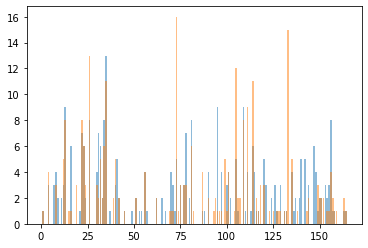

In [49]:
# def plot_this(true_df, predicted_df):
#     plt.figure(figsize=(30,20))
#     n_min = 165
#     freq_true = true_df[true_df[0] < n_min].groupby([0]).size()
#     print(freq_true)
#     freq_pred = predicted_df[predicted_df[0] < n_min].groupby([0]).size()
#     plt.bar(freq_pred.index, freq_pred, label='predicted', alpha=0.5)
#     plt.bar(freq_true.index, freq_true, label='true', alpha=0.5)
#     plt.title('Neuron Firing Distribution (PSTH Loss)', fontsize=40)
#     plt.legend(fontsize=30)
#     plt.show()

df_15_freq = df_1.groupby(['ID']).size()
df_16_freq = df_2.groupby(['ID']).size()

plt.bar(df_15_freq.index, df_15_freq, label='predicted', alpha=0.5)
plt.bar(df_16_freq.index, df_16_freq, label='true', alpha=0.5)

In [50]:
# labels = [round(window + window*n, 2) for n in range(0, int(max(df_pred['Time']) / window))]

# def group_intervals(df, dt):
#     window = dt
#     bins = int(max(df['Time']) / window)
#     intervals = pd.cut(df['Time'], bins=int(max(df['Time']) / window))
#     labels = [round(window + window*n, 2) for n in range(0, int(max(df['Time']) / window))]
#     indexes = [n for n in range(0, int(max(df['Time']) / window))]
#     df['Interval'] = pd.cut(df['Time'], bins=int(max(df['Time']) / window), labels=labels).astype('float32')
#     df['Interval_idx'] = pd.cut(df['Time'], bins=int(max(df['Time']) / window), labels=indexes)
#     df = df.reset_index().drop(['index'], axis=1)
#     return df

# df_pred = group_intervals(df_pred, window)

labels = [round(window + window*n, 2) for n in range(0, int(max(df['Interval']) / window))]

In [51]:
def get_rates(df, intervals):
    df_true = df.groupby(['True', 'Interval']).count().unstack(fill_value=0).stack()['Predicted']
    df_pred = df.groupby(['Predicted', 'Interval']).count().unstack(fill_value=0).stack()['True']
    def set_rates(df, id, intervals):
        df = df[id]
        rates = np.zeros_like(intervals)
        for i in df.index:
            n = int((i * 2) - 1)
            rates[n] = df[i]            
        return rates
    rates_true = dict()
    rates_pred = dict()
    for id in list(set(df['True'].unique()) & set(df['Predicted'].unique())):
        rates_true[id] = set_rates(df_true, id, intervals)
        rates_pred[id] = set_rates(df_pred, id, intervals)
    return rates_true, rates_pred

In [52]:
def get_rates(df, ids, intervals):
    df = df.groupby(['ID', 'Interval']).count().unstack(fill_value=0).stack()['Time']
    def set_rates(df, id, intervals):
        rates = np.zeros_like(intervals)
        if id not in df.index:
            return rates
        else:
            df = df[id]
            for i in df.index:
                n = int((i * 2) - 1)
                rates[n] = df[i]            
            return rates
    rates = dict()
    for id in ids:
        rates[id] = set_rates(df, id, intervals)
    return rates

ids = list(set(df_1['ID'].unique()) & set(df_2['ID'].unique()))
rates_1 = get_rates(df_1, ids, labels)
rates_2 = get_rates(df_2, ids, labels)

In [53]:
from scipy import stats
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from scipy.special import kl_div

def calc_corr_psth(rates1, rates2):
    pearson_r = dict()
    for id in list((set(rates1.keys()) & set(rates2.keys()))):
        pearson_r[id] = stats.pearsonr(rates1[id], rates2[id])[0]
    # pearson_r = dict(sorted(pearson_r.items(), reverse=True, key=lambda item: item[1]))
    pearson_r = pd.DataFrame(pearson_r, index=['pearson_r']).T.sort_values(by=['pearson_r'], ascending=False)
    return pearson_r


top_corr = calc_corr_psth(rates_1, rates_2)

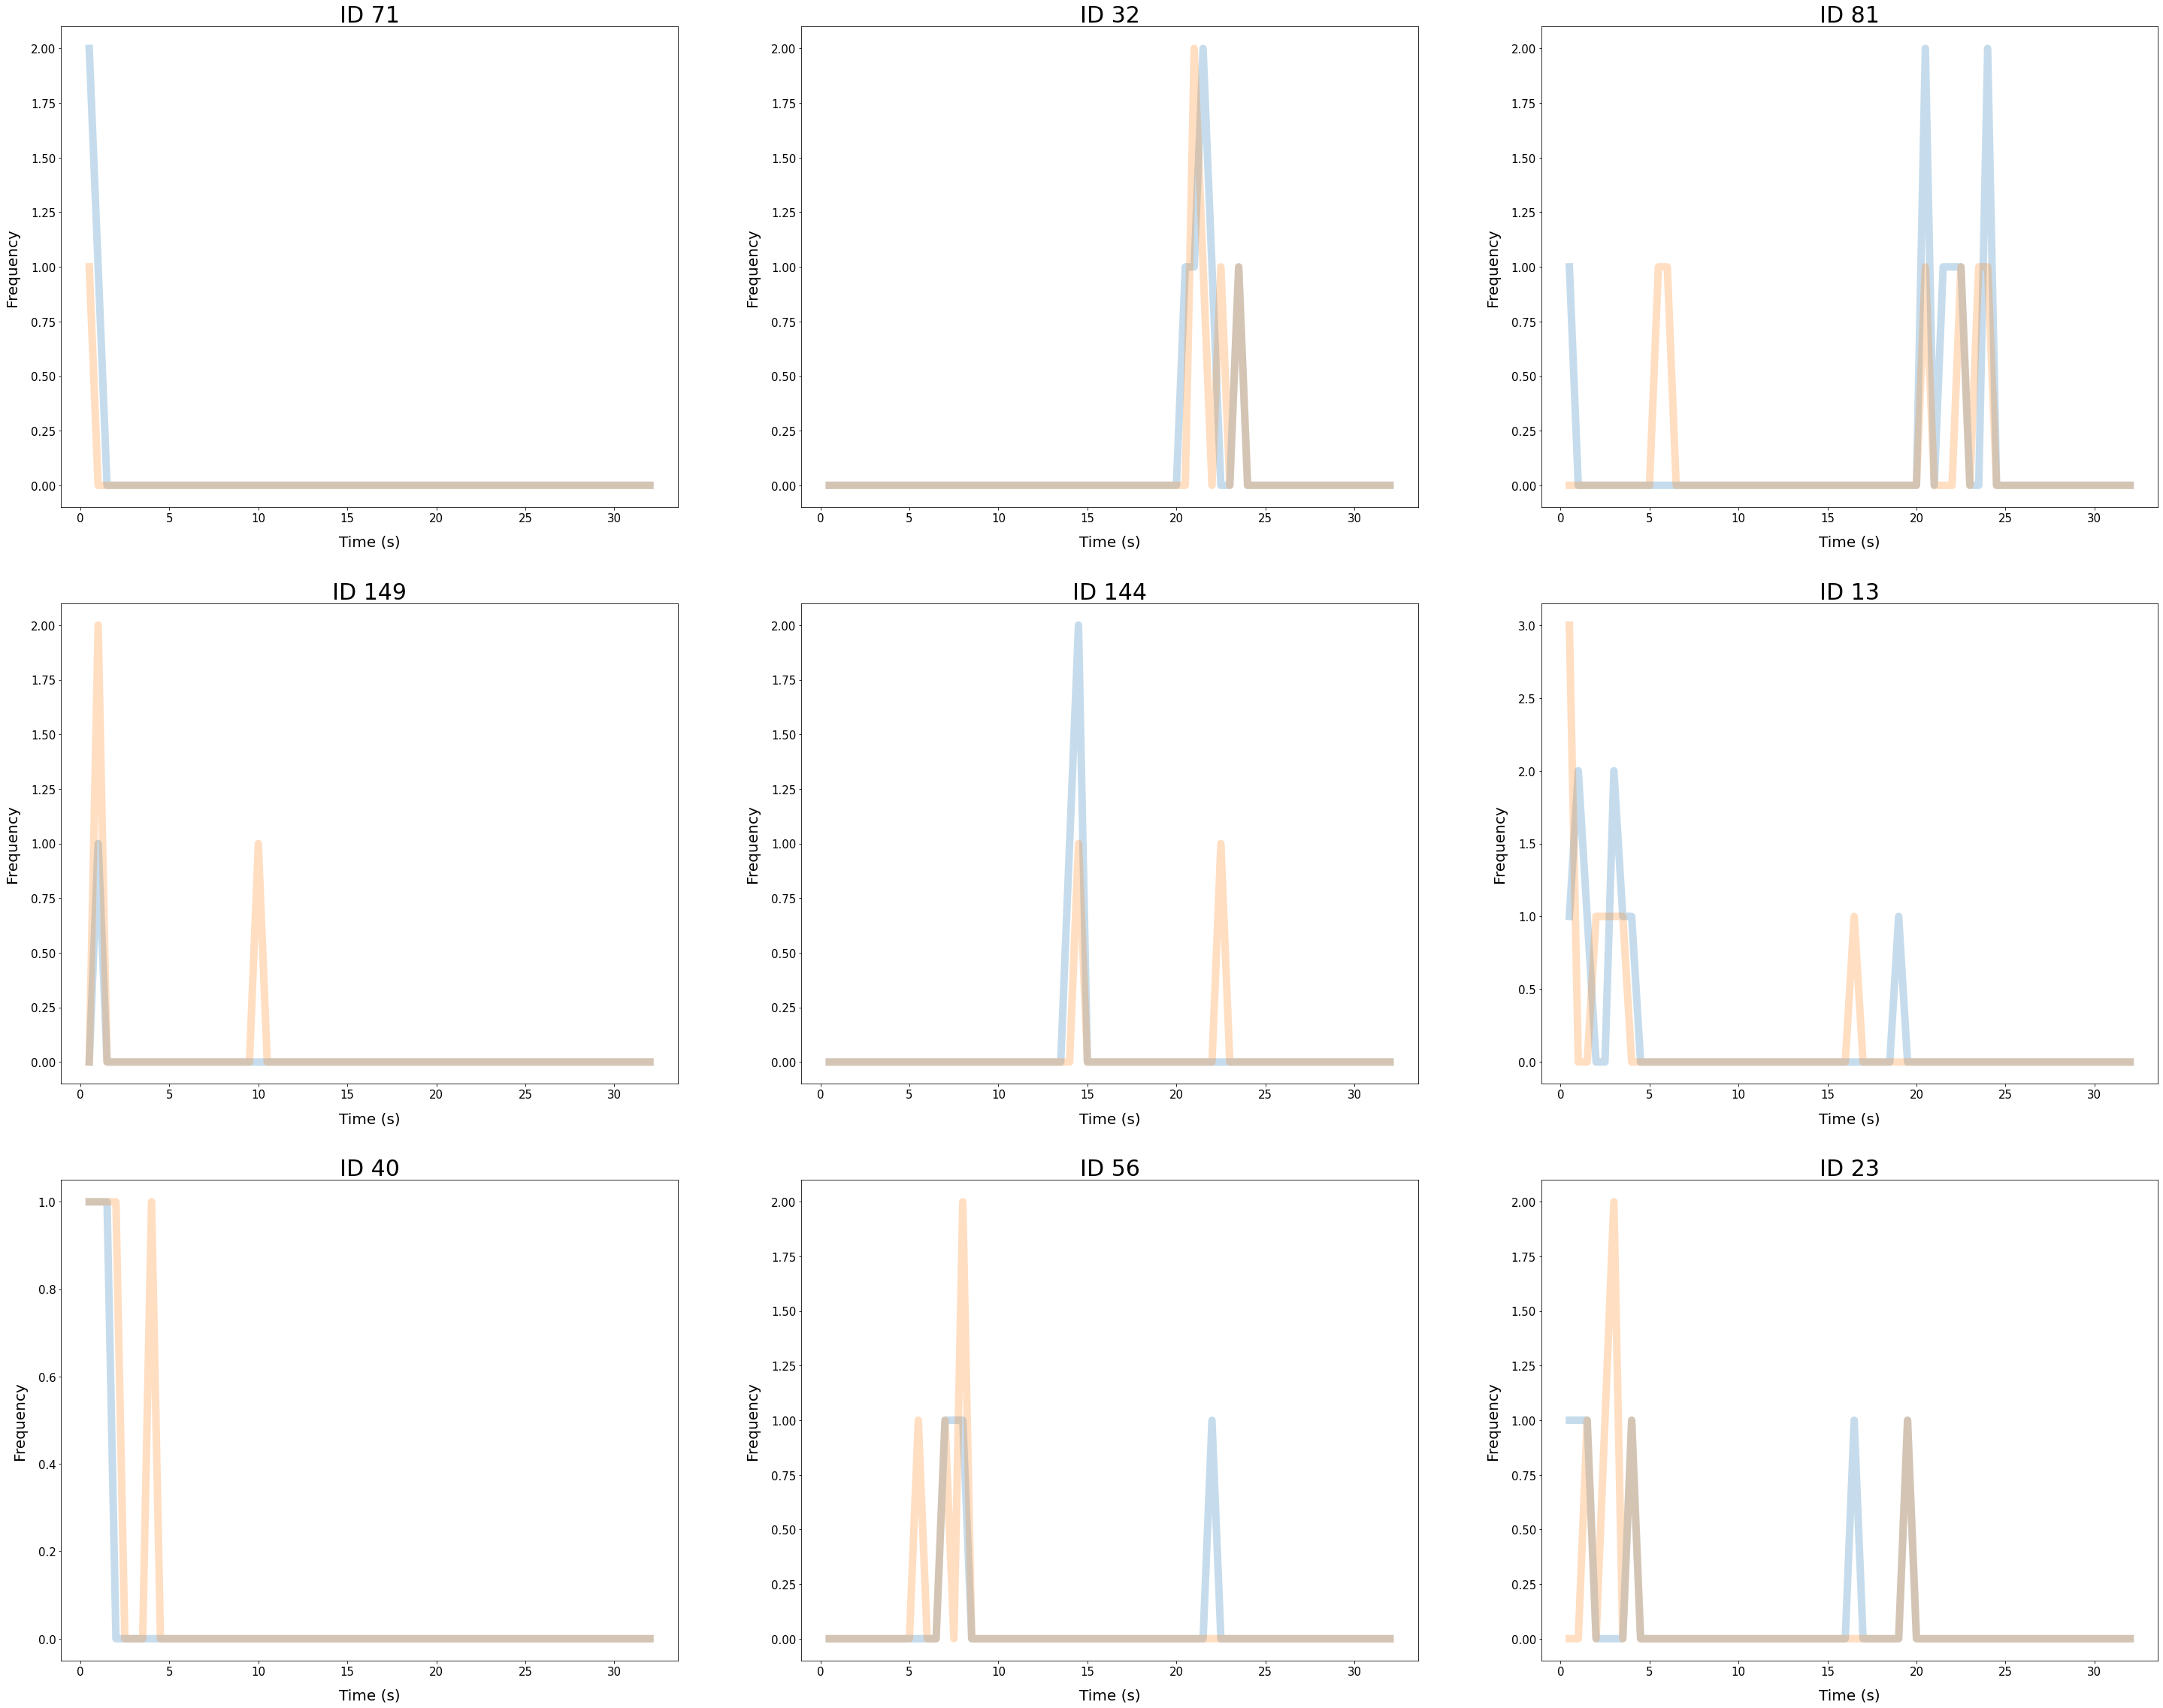

In [54]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelpad'] = 15

cols = 3
rows = 3
plt.figure(figsize=(50, 40))
plt.title('Neuron Firings', size=20)
gs = plt.GridSpec(cols, rows)
for n, id in enumerate(top_corr.index[:cols*rows]):
    i = n % cols
    j = n // cols
    plt.subplot(gs[i, j])
    plt.plot(labels, rates_1[id], alpha=0.25, label='true', linewidth=10)
    plt.plot(labels, rates_2[id], alpha=0.25, label='predicted', linewidth=10)
    plt.title(f'ID {id}', size=30)
    plt.ylabel('Frequency', size=20)
    plt.xlabel('Time (s)', size=20)

In [55]:
def get_rates_trial(df, intervals):
    df_rates = df.groupby(['ID', 'Interval']).count().unstack(fill_value=0).stack()
    def set_rates(df, id, intervals):
        df = df.loc[id]
        rates = np.zeros_like(intervals)
        for i in df.index:
            n = int((i * 2) - 2)
            rates[n] = df['Time'].loc[i] 
        return rates
    rates = dict()
    for id in list(set(df['ID'].unique())):
        rates_id = set_rates(df_rates, id, intervals)
        rates[id] = rates_id
    return rates

In [56]:
# t_1 = 25
# t_2 = 35

# rates_trial_8 = get_rates_trial(df[df['Trial'] == t_1].reset_index(drop=True), labels)
# rates_trial_1 = get_rates_trial(df[df['Trial'] == t_2].reset_index(drop=True), labels)
# corr_trials = calc_corr_psth(rates_trial_1, rates_trial_8)

# # neuron_list = [5 * n for n in range(10)]
# # neuron_list = [5 * n for n in range(10)]
# # neuron_list = df_pred.groupby(['True']).size().nlargest(20).index.tolist()
# neuron_list = top_corr[:20].index.tolist()

# df_pred_8_true = df_pred.iloc[test_data[test_data['Trial'] == t_1].index.tolist()][df_pred['True'].isin(neuron_list)]
# df_pred_8_pred = df_pred.iloc[test_data[test_data['Trial'] == t_1].index.tolist()][df_pred['Predicted'].isin(neuron_list)]
# df_pred_7_true = df_pred.iloc[test_data[test_data['Trial'] == t_2].index.tolist()][df_pred['True'].isin(neuron_list)]

# df_pred_8_true['Time'] -= df_pred_8_true['Time'].max()
# df_pred_8_pred['Time'] -= df_pred_8_pred['Time'].max()
# df_pred_7_true['Time'] -= df_pred_7_true['Time'].max()

# df_pred_8_true_= pd.melt(df_pred_8_true, id_vars='Time', value_vars=['True']).dropna()
# df_pred_8_pred_= pd.melt(df_pred_8_pred, id_vars='Time', value_vars=['Predicted']).dropna()
# df_pred_7_true_ = pd.melt(df_pred_7_true, id_vars='Time', value_vars=['True']).dropna()

In [57]:
def get_spikes(df_pred, df, trial, neuron_list, labels):
    rates_trial = get_rates_trial(get_rates_trial(df[df['Trial'] == trial].reset_index(drop=True), labels))
    df_pred_true = df_pred.iloc[test_data[test_data['Trial'] == trial].index.tolist()][df_pred['True'].isin(neuron_list)]
    df_pred_pred = df_pred.iloc[test_data[test_data['Trial'] == trial].index.tolist()][df_pred['Predicted'].isin(neuron_list)]
    return df_pred_true, df_pred_pred


In [58]:
spacing = np.arange(0, 250, step=250/len(neuron_list))
for ix, neuron in enumerate(df_pred_8_true['True'].unique()):
    df_pred_8_true['True'][df_pred_8_true['True'] == neuron] = spacing[ix]
    df_pred_8_pred['Predicted'][df_pred_8_pred['Predicted'] == neuron] = spacing[ix]
    df_pred_7_true['True'][df_pred_7_true['True'] == neuron] = spacing[ix]

NameError: name 'neuron_list' is not defined

In [59]:
plt.figure(figsize=(13, 13))

plt.scatter(df_pred_8_pred['Time'], df_pred_8_pred['Predicted'], color='#45b3e0', marker="|", s=100, label='Simulated')
plt.scatter(df_pred_8_true['Time'], df_pred_8_true['True'] + 0, color='#b3e045', marker="|", s=100, label=f'Trial {t_1}')
plt.scatter(df_pred_7_true['Time'], df_pred_7_true['True'] - 0, color='#e045b3', marker="|", s=100, label=f'Trial {t_2}')

# plt.yticks(np.arange(0, len(neuron_list), step=160 / len(neuron_list)))
plt.legend(loc=2, fontsize=15, title_fontsize=15)
plt.title('Spike Raster', fontsize=25)
plt.ylabel('Neuron ID', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)

NameError: name 'df_pred_8_pred' is not defined

<Figure size 936x936 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

# some random data
x = np.random.randn(1000)
y = np.random.randn(1000)


def scatter_hist(x, y, ax, ax_histy):
    # no labels
    # ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    # ax.scatter(x, y)
    # bins = 250

    # now determine nice limits by hand:
    # binwidth = 0.25
    # xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    # lim = (int(xymax/binwidth) + 1) * binwidth

    # bins = np.arange(-lim, lim + binwidth, binwidth)
    # ax_histx.hist(x, bins=bins)
    ax_hist = sns.distplot(y,  hist=False, ax=ax_histy, vertical=True) # (x, y, bins=10, orientation='horizontal')
    ax_hist.set(xlabel=None)

    # sns.distplot(top_corr, hist=False, ax=ax_histy, vertical=True)


In [ ]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(15, 15))

ax = fig.add_axes(rect_scatter)
# ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(np.array(corr_trials.index), corr_trials, ax, ax_histy)
scatter_hist(np.array(top_corr.index), top_corr, ax, ax_histy)
ax.grid(lw=0.8, alpha=0.7, color='gray')
ax.scatter(corr_trials.index, corr_trials, label=f'Trial {t_1} vs. 1', alpha=0.4)
ax.scatter(top_corr.index, top_corr, label=f'Trial {t_1} vs. Pred', alpha=0.5)
ax.set_title('Pair-wise Correlation Between Trials', fontsize=25)
ax.set_xlabel('Neuron ID', fontsize=20)
ax.set_ylim(-0.1, 0.6)
plt.ylabel('Pearson Correlation (p)')
ax.legend(fontsize=20, title_fontsize=20)
plt.show()

In [60]:
''' Inter trial Event '''

def get_inter_trial_event(df):
    df_inter_trial = np.array(df['Time'][1:]) - np.array(df['Time'][:-1])
    return df_inter_trial

len_event = min(len(df_1), len(df_2)) - 1
it_event_1 = get_inter_trial_event(df_1)[:len_event]
it_event_2 = get_inter_trial_event(df_2)[:len_event]

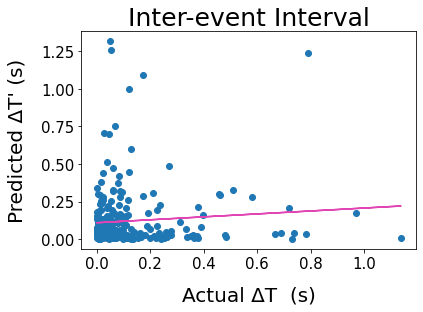

In [62]:
it_event_fit = np.polyfit(it_event_1, it_event_2, 1)
plt.title('Inter-event Interval', fontsize=25)
plt.xlabel('Actual ΔT  (s)', fontsize=20)
plt.ylabel("Predicted ΔT' (s)", fontsize=20)
plt.scatter(it_event_1, it_event_2)
plt.plot(it_event_1, it_event_fit[0] * it_event_1 + it_event_fit[1], color='#e045b3')

In [63]:
''' Trial-Averaged Spike Number '''

df_1_mean_spikes = df_1.groupby(['ID', 'Trial']).count().loc[ids].sort_index()['Time']
df_2_mean_spikes = df_2.groupby(['ID', 'Trial']).count().loc[ids].sort_index()['Time']

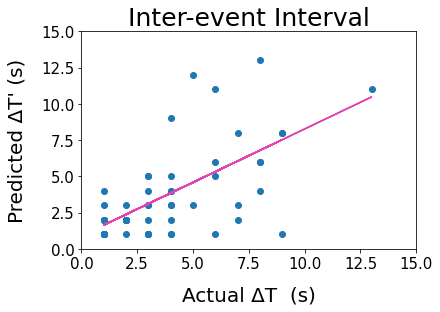

In [64]:
mean_spike_fit = np.polyfit(df_1_mean_spikes, df_2_mean_spikes, 1)
plt.title('Inter-event Interval', fontsize=25)
plt.xlabel('Actual ΔT  (s)', fontsize=20)
plt.ylabel("Predicted ΔT' (s)", fontsize=20)
plt.ylim(0, 15)
plt.xlim(0, 15)
plt.scatter(df_1_mean_spikes, df_2_mean_spikes)
plt.plot(df_1_mean_spikes, mean_spike_fit[0] * df_1_mean_spikes + mean_spike_fit[1], color='#e045b3')

In [65]:
df_10_20 = df[(df['Trial'] < 20) & (df['Trial'] >= 0)].groupby(['ID']).count()

In [66]:
df_10_20 = df[(df['Trial'] < 20) & (df['Trial'] >= 10) & (df['ID'] == 20)]
df_0_10 = df[(df['Trial'] < 10) & (df['ID'] == 20)]

In [67]:
df_n30 = df[(df['Trial'] < 30) & (df['ID'] == 20)]
df_30n = df[(df['Trial'] >= 30) & (df['ID'] == 20)]

def get_event_time_std(df):
    time_std = []
    for trial in df['Trial'].unique():
        time_std.append(df['Time'][df['Trial'] == trial].std(ddof=0))
    return np.array(time_std)

time_std_1 = get_event_time_std(df_n30)
time_std_2 = get_event_time_std(df_30n)
min_len_time_std = min(len(time_std_1), len(time_std_2))
time_std_1 = time_std_1[:min_len_time_std]
time_std_2 = time_std_2[:min_len_time_std]


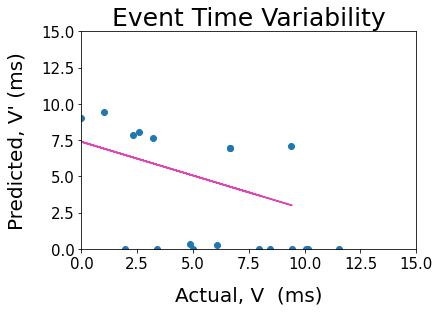

In [68]:
''' Event Time Variability '''

time_std_fit = np.polyfit(time_std_1, time_std_2, 1)
plt.title('Event Time Variability', fontsize=25)
plt.xlabel('Actual, V  (ms)', fontsize=20)
plt.ylabel("Predicted, V' (ms)", fontsize=20)
plt.ylim(0, 15)
plt.xlim(0, 15)
plt.scatter(time_std_2, time_std_1)
plt.plot(time_std_1, time_std_fit[0] * time_std_1 + time_std_fit[1], color='#e045b3')

In [69]:
''' Spike Number Variability '''

rates = get_rates(df, df['ID'].unique(), labels)
rates = pd.DataFrame(rates)

In [70]:
r1 = get_rates(df[(df['Trial'] == 1)], [20], labels)
r2 = get_rates(df[(df['Trial'] == 2)], [20], labels)

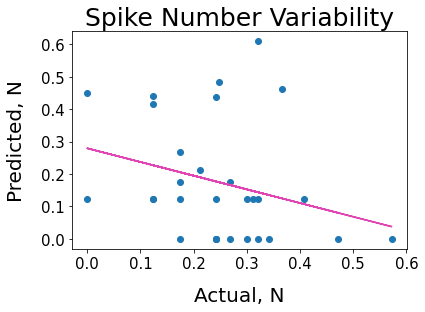

In [71]:
df_10_20 = df[(df['Trial'] < 31)]
df_0_10 = df[(df['Trial'] >= 31)]

def get_spike_number(df, id):
    spike_number = dict()
    for trial in df['Trial'].unique():
        n = len(df[(df['Trial'] == trial) & (df['ID'] == id)])
        spike_number[trial] = n if n > 0 else 0
    return np.array(pd.DataFrame(spike_number, index=[0])).flatten()

def get_spike_std(df, id, intervals):
    rates = dict()
    for trial in df['Trial'].unique():
        rate_trial = get_rates(df[(df['Trial'] == trial)], id, intervals)
        # std = pd.DataFrame(rates).std(ddof=0)
        rates[trial] = list(rate_trial.values())[0]
    # return rates
    rates = pd.DataFrame(rates)
    # return rates
    return rates.std(axis=0, ddof=0)

ids = [20]      
spike_number_1 = get_spike_std(df_0_10, ids, labels)
spike_number_2 = get_spike_std(df_10_20, ids, labels)

# idn = 20
# spike_number_1 = get_spike_number(df_0_10, idn)
# spike_number_2 = get_spike_number(df_10_20, idn)

''' Spike Number Variability '''

spike_number_fit = np.polyfit(spike_number_1, spike_number_2, 1)
plt.title('Spike Number Variability', fontsize=25)
plt.xlabel('Actual, N', fontsize=20)
plt.ylabel("Predicted, N", fontsize=20)
# plt.ylim(0, 15)
# plt.xlim(0, 15)
plt.scatter(spike_number_1, spike_number_2)
plt.plot(spike_number_1, spike_number_fit[0] * spike_number_1 + spike_number_fit[1], color='#e045b3')


In [72]:
from utils import set_plot_params, set_plot_white

set_plot_params()
set_plot_white()

In [73]:
def custom_lineplot(ax, x, y, error, xlims, ylims, color='red'):
    """Customized line plot with error bars."""
    
    ax.errorbar(x, y, yerr=error, color=color, ls='--', marker='o', capsize=5, capthick=1, ecolor='black')
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    return ax

def custom_scatterplot(ax, x, y, error, xlims, ylims, color='green', markerscale=100):
    """Customized scatter plot where marker size is proportional to error measure."""
    
    markersize = error * markerscale
    
    ax.scatter(x, y, color=color, marker='o', s=markersize, alpha=0.5)
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    return ax


def stylize_axes(ax, xticks, yticks, xticklabels, yticklabels):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    ax.set_xlim(ax.get_xlim()[0] - ax.get_xlim()[1]*0.05, ax.get_xlim()[1]*1.05)
    ax.set_ylim(ax.get_ylim()[0] - ax.get_ylim()[1]*0.05, ax.get_ylim()[1]*1.05)

    ax.tick_params(top="off", right="off")

In [74]:
def get_lims(arr1, arr2):
    return math.ceil(max([np.max(arr1), np.max(arr1)]))

In [75]:
def plot_scatter_line(ax, x, y, title, xlabel, ylabel, color='red'):
    lims = get_lims(x, y)
    ax.set_xlim(0, lims)
    ax.set_ylim(0, lims)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.scatter(x, y, color='blue', marker='o', s=100, alpha=0.5)
    reg_line = np.polyfit(x, y, 1)
    ax.plot(x, reg_line[0] * x + reg_line[1], color=color)
    return ax


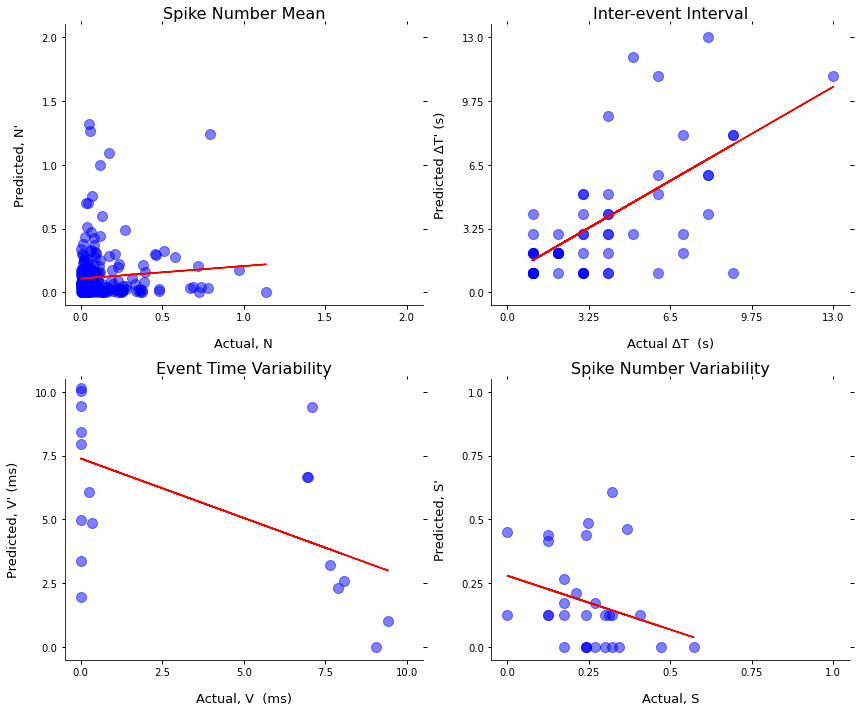

In [76]:
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10    
plt.rcParams['axes.labelweight'] = 'normal'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

plot_scatter_line(ax[0][0], it_event_1, it_event_2, 'Spike Number Mean', 'Actual, N', 'Predicted, N\'', color='red')
plot_scatter_line(ax[0][1], df_1_mean_spikes, df_2_mean_spikes, 'Inter-event Interval', 'Actual ΔT  (s)', 'Predicted ΔT\' (s)', color='red')
plot_scatter_line(ax[1][0], time_std_1, time_std_2, 'Event Time Variability', 'Actual, V  (ms)', 'Predicted, V\' (ms)', color='red')
plot_scatter_line(ax[1][1], spike_number_1, spike_number_2, 'Spike Number Variability', 'Actual, S', 'Predicted, S\'', color='red')

for i, axes in enumerate(ax.flat):
    # Customize y ticks on a per-axes basis
    xticks = np.linspace(axes.get_xlim()[0], axes.get_xlim()[1], 5)
    xticklabels = xticks
    yticks = np.linspace(axes.get_ylim()[0], axes.get_ylim()[1], 5)
    yticklabels = yticks
    stylize_axes(axes, xticks, yticks, xticklabels, yticklabels)

fig.tight_layout()

fig.savefig('Statistics_real.png', dpi=300, bbox_inches='tight', transparent=False)